# **American Express 2021 Challenge**

## Akash

## Loading Packages

In [ ]:
import os
import json
import re
import random
import plotly
import nltk
import time
nltk.download('wordnet')
import nltk
import pandas as pd
import numpy as np
import scipy as scipy
import seaborn as sns
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from tensorflow import keras
from sklearn.feature_extraction.text import CountVectorizer
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as graph
from collections import Counter
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
import sklearn.metrics
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras import backend as K 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, Bidirectional, Lambda, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(pred_test_df['image_id'].unique)

NameError: ignored

## Load Data

In [ ]:
# github path for loading data
!git clone https://github.com/rawakash66/AMEX_2021_Data_Science_Challenge -q

In [ ]:
# moving into the directory
%cd AMEX_2021_Data_Science_Challenge

/content/AMEX_2021_Data_Science_Challenge


In [ ]:
# unzipping files
!unzip -qq "train.zip"
!unzip -qq "val.zip"
!unzip -qq "test.zip"
!unzip -qq "csvFiles.zip"
print("files unzipped")

files unzipped


In [ ]:
# file paths for input and label data
train_input_path = "train/input"
train_output_path = "train/output"
val_input_path = "round1/input"
test_input_path = "round2/input"
train_csv_path = "csvFiles/train.csv"
val_csv_path = "csvFiles/round1.csv"
test_csv_path = "csvFiles/round2.csv"

# CSV ANALYSIS

In [ ]:
csv_train = pd.read_csv(train_csv_path, encoding ='utf-8')
csv_train.head()

,image_id,textAnnotation_id,x0,y0,x1,y1,x2,y2,x3,y3,description,label
0,image_0000,0,88.0,0.0,141.0,2.0,140.0,33.0,87.0,32.0,S3,others
1,image_0000,1,218.0,98.0,327.0,98.0,327.0,113.0,218.0,113.0,merchant name,others
2,image_0000,2,220.0,112.0,316.0,112.0,316.0,121.0,220.0,121.0,merchant name,others
3,image_0000,3,220.0,124.0,309.0,123.0,309.0,135.0,220.0,135.0,merchant address,others
4,image_0000,4,116.0,174.0,241.0,174.0,241.0,191.0,116.0,191.0,merchant address,others


In [ ]:
csv_val = pd.read_csv(val_csv_path, encoding = 'utf-8')
csv_val.head()

,image_id,textAnnotation_id,x0,y0,x1,y1,x2,y2,x3,y3,description
0,image_0197,0,10.0,82.0,29.0,82.0,29.0,114.0,10.0,114.0,merchant name
1,image_0197,1,12.0,116.0,60.0,116.0,60.0,136.0,12.0,136.0,merchant address
2,image_0197,2,12.0,136.0,38.0,136.0,38.0,157.0,12.0,157.0,Tel
3,image_0197,3,35.0,82.0,100.0,82.0,100.0,115.0,35.0,115.0,merchant name
4,image_0197,4,63.0,117.0,91.0,117.0,91.0,137.0,63.0,137.0,WAN


In [ ]:
csv_test = pd.read_csv(test_csv_path, encoding = 'utf-8')
csv_test.head()

,image_id,textAnnotation_id,x0,y0,x1,y1,x2,y2,x3,y3,description
0,image_0201,0,377.0,8.0,377.0,87.0,351.0,87.0,351.0,8.0,Cards
1,image_0201,1,33.0,33.0,207.0,33.0,207.0,57.0,33.0,57.0,ICE IS INCLUSIVE
2,image_0201,2,211.0,33.0,247.0,33.0,247.0,57.0,211.0,57.0,GST
3,image_0201,3,13.0,88.0,13.0,3.0,38.0,3.0,38.0,88.0,Americ
4,image_0201,4,125.0,181.0,227.0,182.0,227.0,204.0,125.0,203.0,merchant name


## Data Cleaning

In [ ]:
import string

def remove_punctuation(s:str):
    for char in string.punctuation:
        s = s.replace(char, '')
        s = re.sub(r'\W+', '', s)
    return s

In [ ]:
# converting text into lowercase and dropping x1, x3, y1, y3 as they are redundant
csv_train.drop(columns=['x1', 'x3', 'y1', 'y3'], inplace=True)
csv_val.drop(columns=['x1', 'x3', 'y1', 'y3'], inplace=True)
csv_test.drop(columns=['x1', 'x3', 'y1', 'y3'], inplace=True)
csv_train['description'] = csv_train['description'].str.strip().str.lower()
csv_val['description'] = csv_val['description'].str.strip().str.lower()
csv_test['description'] = csv_test['description'].str.strip().str.lower()

In [ ]:
# normalize coordinates values
mx_x = max(csv_train['x2'])
mx_y = max(csv_train['y2'])
csv_train[['x0','x2']] = csv_train[['x0','x2']]/mx_x
csv_train[['y0','y2']] = csv_train[['y0','y2']]/mx_y
csv_val[['x0','x2']] = csv_val[['x0','x2']]/mx_x
csv_val[['y0','y2']] = csv_val[['y0','y2']]/mx_y
csv_test[['x0','x2']] = csv_test[['x0','x2']]/mx_x
csv_test[['y0','y2']] = csv_test[['y0','y2']]/mx_y

In [ ]:
csv_train['description'] = csv_train['description'].apply(remove_punctuation)
csv_val['description'] = csv_val['description'].apply(remove_punctuation)
csv_test['description'] = csv_test['description'].apply(remove_punctuation)

## Word2Vec

In [ ]:
# train word2vec model
sent = list(pd.concat([csv_train['description'], csv_val['description'], csv_test['description']], axis=0, ignore_index=True).values)
sent = list(map(lambda x:[x], sent))
model = Word2Vec(sentences=sent, min_count=1)
print(model)
# Words trained in the model vocabulary
words = list(model.wv.vocab)
print(words)

Word2Vec(vocab=18146, size=100, alpha=0.025)
['s3', 'merchantname', 'merchantaddress', 'merchantphone', 'check44167', 'table3', '07111912', '1', 'refreshingtunapokericebowl', 'coke', '158', '28', 'subtotal', 'servicecharge', '186', '18', 'total', '2046', 'chk712991', '111520190845am', '2reg', '1513490', 'drawer', 'berrytrioyogurt', 'grflatwhite', '395', '495', 'amex', 'xxxxxxxxxxxx1000', 'quickchip', 'purchase', 'reference', 'applabel', 'auth', 'aid', 'tvr', 'tsi', '890', 'cardentry', 'transtype', '00000135', 'americanexpress', '803099', 'a000000025010801', '0000008000', 'e800', 'changedue', '000', 'checkclosed', 'joinourloyaltyprogram', 'signupforpromotionalemails', 'ordownloadourapp', 'somerestrictionsapply', 'starbucksrewards', 'visitstarbuckscomrewards', 'atparticipatingstores', 'date', 'cardtype', 'acct', 'authcode', 'check', 'checkid', 'server', 'oct28190905am', 'xxxxxxxxxxx1000', 'swiped', '585879', '1746', '20', '1006cashier', '', '3417', 'tip', 'guestcopy', 'll', 'vodafonein',

In [ ]:
# Remove rows that are not part of model vocabulary
train_unique = csv_train[csv_train['description'].isin(words)]
# Update text and label according to train_unique with each row unique
text = np.array(train_unique['description'])
labels = np.array(train_unique['label'])
print(list(text))
print(labels.shape)

['s3', 'merchantname', 'merchantname', 'merchantaddress', 'merchantaddress', 'merchantphone', 'merchantaddress', 'merchantaddress', 'check44167', 'table3', '07111912', '1', 'refreshingtunapokericebowl', 'coke', '1', '158', '28', 'subtotal', 'servicecharge', '186', '18', 'total', '2046', 'merchantname', 'merchantaddress', 'merchantphone', 'merchantaddress', 'chk712991', '111520190845am', '2reg', '1513490', 'drawer', '1', 'berrytrioyogurt', 'grflatwhite', '395', '495', 'amex', 'xxxxxxxxxxxx1000', 'quickchip', 'purchase', 'reference', 'applabel', 'auth', 'aid', 'tvr', 'tsi', '890', 'cardentry', 'transtype', '00000135', 'americanexpress', '803099', 'a000000025010801', '0000008000', 'e800', 'subtotal', 'total', 'changedue', '890', '890', '000', 'checkclosed', '111520190845am', 'joinourloyaltyprogram', 'signupforpromotionalemails', 'ordownloadourapp', 'somerestrictionsapply', 'starbucksrewards', 'visitstarbuckscomrewards', 'atparticipatingstores', 'date', 'cardtype', 'acct', 'cardentry', 'tr

In [ ]:
# Training input
x_train = model[train_unique['description']]
x0 = train_unique['x0'].values
x0 = x0.reshape(-1,1)
y0 = train_unique['y0'].values
y0 = y0.reshape(-1,1)
x2 = train_unique['x2'].values
x2 = x2.reshape(-1,1)
y2 = train_unique['y2'].values
y2 = y2.reshape(-1,1)
x_train = np.hstack((x_train,x0,y0,x2,y2))
x_train.shape

(48174, 104)

In [ ]:
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(train_unique['label'].values)
classes = list(encoder.classes_)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Y)
print(y_train.shape)
print(classes)

(48174, 10)
['0 description beginning', '1 description inside', '2 tax total', '3 tip', '5 total price per item', 'e quantity', 'others', 'sub total', 'total amount', 'unit price']


In [ ]:
# calculates class weights where pos_weight = neg_freq and neg_weight = pos_freq
def compute_class_freqs(labels):
    
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

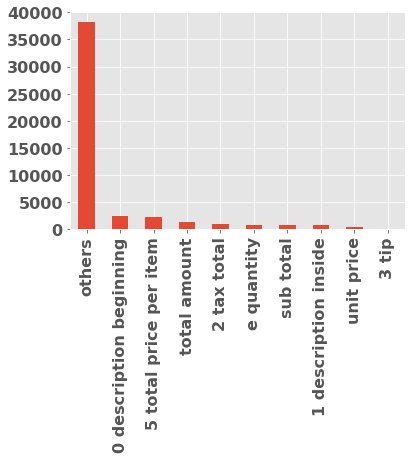

In [ ]:
# plot for class frequency imbalance
plt.style.use('ggplot')
from matplotlib import rc
rc('font', weight='bold')
ax = train_unique['label'].value_counts().plot(kind='bar', fontsize = 16)

list of class names: ['0 description beginning', '1 description inside', '2 tax total', '3 tip', '5 total price per item', 'e quantity', 'others', 'sub total', 'total amount', 'unit price']
positive weights: [0.9505335  0.98214805 0.9797401  0.9968863  0.95348114 0.9815253
 0.20799601 0.982065   0.9730975  0.99252707]
negative weights: [0.04946652 0.01785195 0.02025989 0.00311371 0.04651887 0.0184747
 0.792004   0.01793499 0.02690248 0.00747291]


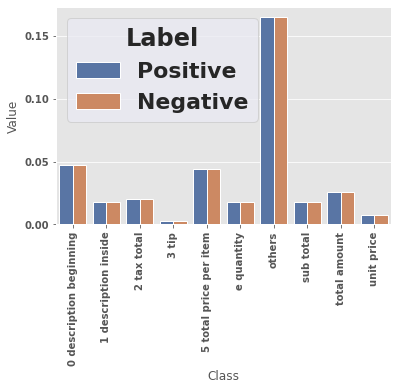

In [ ]:
# balancing the class frequencies by assinging the weights 
pos_freq, neg_freq = compute_class_freqs(y_train)
neg_weights = pos_freq
pos_weights = neg_freq

pos_contribution = pos_freq * pos_weights 
neg_contribution = neg_freq * neg_weights

print('list of class names:', classes)
print('positive weights:', pos_weights)
print('negative weights:', neg_weights)

# plt.figure(figsize = (12,5))

plotData = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_contribution})
plotData = plotData.append([{"Class": classes[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
# plt.yticks(fontsize = 16)
sns.set(font_scale = 2)
sns.barplot(x="Class", y="Value", hue="Label" ,data=plotData)
sns.set_context(rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16,"weight":'bold'})   

In [ ]:
# weighted cross entropy loss function
def get_weighted_loss(pos_weights, neg_weights, epsilon = 1e-7):
  
  
  def weighted_loss(y_true, y_pred):
        loss = 0.0
        loss_pos = - K.mean(pos_weights * y_true * K.log(y_pred + epsilon))
        loss_neg = - K.mean(neg_weights * (1 - y_true) * K.log(1 - y_pred + epsilon))
        loss += loss_pos + loss_neg
        
        return loss


  return weighted_loss

In [ ]:
def get_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=104, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10, activation='softmax'))
	# Compile model
  model.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer='adam', metrics=['accuracy'])
  
  return model

In [ ]:
x, x_val, y, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=12)
print(x.shape)
print(y.shape)
print(x_val.shape)
print(y_val.shape)

(43356, 104)
(43356, 10)
(4818, 104)
(4818, 10)


In [ ]:
nnModel = get_model()
history = nnModel.fit(x, y, steps_per_epoch = x.shape[0]//1000, epochs = 100, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/100
43/43 [==============================] - 4s 29ms/step - loss: 0.0781 - accuracy: 0.7745 - val_loss: 0.0733 - val_accuracy: 0.7920
Epoch 2/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0703 - accuracy: 0.7786 - val_loss: 0.0673 - val_accuracy: 0.7455
Epoch 3/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0651 - accuracy: 0.6965 - val_loss: 0.0628 - val_accuracy: 0.7389
Epoch 4/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0602 - accuracy: 0.7126 - val_loss: 0.0588 - val_accuracy: 0.6264
Epoch 5/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0576 - accuracy: 0.6695 - val_loss: 0.0569 - val_accuracy: 0.7013
Epoch 6/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0563 - accuracy: 0.6515 - val_loss: 0.0558 - val_accuracy: 0.7084
Epoch 7/100
43/43 [==============================] - 1s 24ms/step - loss: 0.0555 - accuracy: 0.6445 - val_loss: 0.0555 - val_accuracy: 0.6706
Epoch 

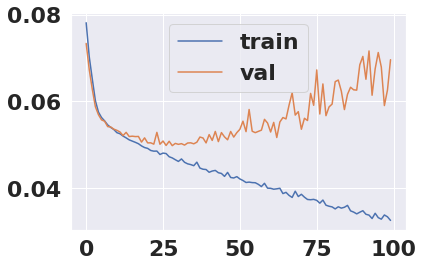

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# neural network prediction
prob_nn = nnModel.predict(x_val)
pred_nn = np.argmax(prob_nn, axis=-1)
y_true = np.argmax(y_val, axis=-1)
score = metrics.f1_score(y_true, pred_nn, labels=range(len(classes)), average='macro')
print('f1-score', score)

f1-score 0.3280265366170384


In [ ]:
def read_test_files(inputPath):
  json_inputfiles_list = sorted([json_file for json_file in os.listdir(inputPath) if json_file.endswith('.json')])
  json_data = pd.DataFrame(columns=['image_id','description', 'coords'])
  
  for idx, img in enumerate(json_inputfiles_list):
    name = img.split('.')[0]
    with open(os.path.join(inputPath,img)) as json_file:
      json_text = json.load(json_file)
      text = [remove_punctuation(json_text['textAnnotations'][i]['description'].strip().lower()) for i in range(len(json_text['textAnnotations']))]
      coords = [[json_text['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'], json_text['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'], \
                 json_text['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'], json_text['textAnnotations'][i]['boundingPoly']['vertices'][2]['y']] \
                for i in range(len(json_text['textAnnotations']))]
      json_data.loc[idx] = [name, text, coords]
  
  return json_data

def get_dict_predict(estimator, dataframe, embed):
  output = {}
  for i in range(dataframe.shape[0]):
    preds = [classes[np.argmax(estimator.predict(np.resize(np.append(np.append(np.append(np.append(embed[dataframe.loc[i,'description'][j]], \
             float(dataframe.loc[i,'coords'][j][0])/mx_x), float(dataframe.loc[i,'coords'][j][1])/mx_y), float(dataframe.loc[i,'coords'][j][2])/mx_x), \
             float(dataframe.loc[i,'coords'][j][3])/mx_y), (1,104))), axis = -1)[0]] for j in range(len(dataframe.loc[i,'description']))]
    preds = dict(zip(range(len(preds)), preds))
    output[dataframe.loc[i,'image_id']] = preds

  return output

In [ ]:
pred_val_df = read_test_files(val_input_path)
pred_val_df.head()

,image_id,description,coords
0,image_0197,"[merchantname, merchantaddress, tel, merchantn...","[[10.0, 82.0, 29.0, 114.0], [12.0, 116.0, 60.0..."
1,image_0198,"[merchantname, merchantaddress, merchantphone,...","[[91.0, 98.0, 332.0, 122.0], [146.0, 129.0, 28..."
2,image_0199,"[11132019, 1041, , merchantname, check, server...","[[33.0, 87.0, 112.0, 106.0], [246.0, 90.0, 282..."
3,image_0200,"[merchantname, merchantaddress, merchantaddres...","[[40.0, 212.0, 314.0, 236.0], [41.0, 245.0, 27..."
4,image_0991,"[, page, down, , , merchantname, merchantaddre...","[[33.0, 15.0, 45.0, 25.0], [388.0, 41.0, 417.0..."


In [ ]:
output_nn = get_dict_predict(nnModel, pred_val_df, model)
print(output_nn)

{'image_0197': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: 'others', 6: 'others', 7: 'others', 8: '1 description inside', 9: '0 description beginning', 10: 'others', 11: 'others', 12: '1 description inside', 13: '1 description inside', 14: 'others', 15: '5 total price per item', 16: '5 total price per item', 17: 'others', 18: 'others', 19: 'others', 20: 'others', 21: 'sub total', 22: '1 description inside', 23: '2 tax total', 24: 'e quantity', 25: '2 tax total', 26: 'others', 27: 'unit price', 28: '2 tax total', 29: 'e quantity', 30: 'others', 31: '1 description inside', 32: 'others', 33: '0 description beginning', 34: 'others', 35: '0 description beginning', 36: '0 description beginning', 37: 'others', 38: 'others', 39: 'others', 40: 'total amount', 41: 'others', 42: 'total amount', 43: 'total amount', 44: 'others', 45: '2 tax total', 46: 'others', 47: '2 tax total', 48: '2 tax total', 49: 'others', 50: 'others', 51: 'others', 52: 'others', 53: 'others', 54: '

In [ ]:
with open("DS_IITK_Dataholic_11.json", "w") as outfile:
    json.dump(output_nn, outfile, sort_keys=True)

In [ ]:
pred_test_df = read_test_files(test_input_path)
pred_test_df.head()

,image_id,description,coords
0,image_0201,"[cards, iceisinclusive, gst, americ, merchantn...","[[377.0, 8.0, 351.0, 87.0], [33.0, 33.0, 207.0..."
1,image_0203,"[merchantname, merchantaddress, merchantaddres...","[[75.0, 66.0, 429.0, 100.0], [75.0, 127.0, 279..."
2,image_0204,"[merchantname, merchantaddress, merchantname, ...","[[560.0, 336.0, 738.0, 376.0], [484.0, 380.0, ..."
3,image_0205,"[merchantname, expectmorepayless, , merchantad...","[[697.0, 464.0, 1275.0, 580.0], [727.0, 579.0,..."
4,image_0213,"[intel, corey, vpto, 8thg, merchantname, ticke...","[[2123.0, 428.0, 2188.0, 448.0], [2125.0, 464...."


In [ ]:
output_test = get_dict_predict(nnModel, pred_test_df, model)
print(output_test)

{'image_0201': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: '0 description beginning', 6: 'others', 7: 'others', 8: 'others', 9: '5 total price per item', 10: '2 tax total', 11: '1 description inside', 12: 'others', 13: 'e quantity', 14: 'total amount', 15: 'others'}, 'image_0203': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: 'others', 6: 'others', 7: 'others', 8: '0 description beginning', 9: '0 description beginning', 10: '5 total price per item', 11: '0 description beginning', 12: '5 total price per item', 13: 'others', 14: 'others', 15: '5 total price per item', 16: '2 tax total', 17: 'others', 18: 'others', 19: 'sub total', 20: '5 total price per item'}, 'image_0204': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: '0 description beginning', 6: 'total amount', 7: 'others', 8: 'others', 9: '0 description beginning', 10: 'others', 11: 'others', 12: 'others', 13: 'others', 14: '0 description beginning', 15: 'total a

## Combine backchodi with Word2Vec model

In [ ]:
def combine_dict(dict1, dict2):
  output = dict1
  
  for k in list(dict1.keys()):
    for idx in list(dict1[k].keys()):
      if dict1[k][idx] == 'others' and dict2[k][idx] != 'others':
        output[k][idx] = dict2[k][idx]
  
  return output

In [ ]:
output = combine_dict(final_answers, output_nn)
print(output)

{'image_1003': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: '1 description inside', 5: 'others', 6: 'others', 7: 'others', 8: 'others', 9: '0 description beginning', 10: 'others', 11: 'others', 12: 'others', 13: 'others', 14: 'others', 15: '5 total price per item', 16: 'others', 17: 'sub total', 18: 'sub total', 19: 'sub total', 20: 'others', 21: 'others', 22: 'total amount', 23: 'others', 24: 'total amount', 25: '0 description beginning', 26: '0 description beginning', 27: 'total amount', 28: 'others', 29: '0 description beginning', 30: '0 description beginning', 31: 'others', 32: 'others', 33: 'others', 34: '0 description beginning', 35: '1 description inside', 36: 'others'}, 'image_1108': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: 'others', 6: '5 total price per item', 7: '1 description inside', 8: 'others', 9: '5 total price per item', 10: 'total amount', 11: 'others', 12: 'e quantity', 13: 'e quantity', 14: 'e quantity', 15: 'e quantity', 16: '

In [ ]:
with open("DS_IITK_Dataholic_22.json", "w") as outfile:
    json.dump(output, outfile, sort_keys=True)

In [ ]:
submission = combine_dict(test_answers, output_test)
print(submission)

{'image_1169': {0: 'others', 1: 'others', 2: 'others', 3: '5 total price per item', 4: 'others', 5: 'others', 6: 'others', 7: 'others', 8: 'others', 9: 'others', 10: 'others', 11: 'others', 12: 'others', 13: '0 description beginning', 14: 'others', 15: 'others', 16: 'others', 17: '0 description beginning', 18: '0 description beginning', 19: '5 total price per item', 20: '5 total price per item', 21: '5 total price per item', 22: 'others', 23: 'sub total', 24: '2 tax total', 25: 'others', 26: 'others', 27: '2 tax total', 28: 'total amount', 29: '5 total price per item', 30: 'others', 31: 'others', 32: 'others', 33: 'others', 34: 'sub total', 35: '2 tax total', 36: 'others', 37: 'unit price', 38: 'others', 39: 'total amount', 40: 'others', 41: 'others', 42: 'others', 43: 'others', 44: 'others', 45: 'others', 46: 'others', 47: 'others', 48: 'others', 49: 'others', 50: 'others', 51: 'others', 52: 'others', 53: 'others', 54: 'others', 55: 'total amount', 56: 'others'}, 'image_1165': {0: 'ot

In [ ]:
with open("DS_IITK_Dataholic.json", "w") as outfile:
    json.dump(submission, outfile, sort_keys=True)

# Backchodi

In [ ]:
import json,csv, pandas as pd
from os import listdir
from os.path import isfile, join

## Data Loading

In [ ]:
train_path = """train/"""

train_filenames = (sorted([f for f in listdir(train_path+"input") if f.endswith('.json')], key = lambda x: int(x[6:10])), \
             sorted([f for f in listdir(train_path+"output") if f.endswith('.json')], key = lambda x: int(x[6:10])))
paths = (train_path+"input/",train_path+"output/")

##column headers
train_fields = ['image_id', 'textAnnotation_id', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'description', 'label']

In [ ]:
def train_data_extractor(filenames,fields_merge):
    #read input json, extract text ids, vertices and description and store in an array. Convert array to dataframe.
    input_array = []
    for filename in filenames[0]:
        input_file = open(paths[0]+filename,"r")
        input_json = json.loads(input_file.read())
        for i in input_json["textAnnotations"] :
            temp_array = []
            temp_array.append(filename[:-5])
            temp_array.append(input_json["textAnnotations"].index(i))
            for j in i["boundingPoly"]["vertices"] :
                temp_array.append(j["x"])
                temp_array.append(j["y"])
            temp_array.append(i["description"].strip().lower())
            input_array.append(temp_array)
    input_df = pd.DataFrame(input_array, columns = train_fields[:11])
    
    #read output json, extract text ids and label and store in an array. Convert array to dataframe.
    output_array = []
    for filename in filenames[1]:              
        output_file = open(paths[1]+filename,"r")
        output_json = json.loads(output_file.read())
        for j in output_json :
            temp_array = []
            temp_array.append(filename[:10])
            temp_array.append(j["id"])
            temp_array.append(j["label"]) 
            output_array.append(temp_array)
    output_df = pd.DataFrame(output_array, columns = [train_fields[i] for i in [0,1,11]])
    
    #return inner join of the two dataframes based on the fields passed as a parameter to the function. 
    #inner join is also used to remove any rows with NaN
    
    return  pd.merge(input_df, output_df, on= [train_fields[i] for i in fields_merge], how="inner")

In [ ]:
train_df = train_data_extractor(train_filenames,[0,1])
train_df.head()

,image_id,textAnnotation_id,x0,y0,x1,y1,x2,y2,x3,y3,description,label
0,image_0000,0,88.0,0.0,141.0,2.0,140.0,33.0,87.0,32.0,s3,others
1,image_0000,1,218.0,98.0,327.0,98.0,327.0,113.0,218.0,113.0,merchant name,others
2,image_0000,2,220.0,112.0,316.0,112.0,316.0,121.0,220.0,121.0,merchant name,others
3,image_0000,3,220.0,124.0,309.0,123.0,309.0,135.0,220.0,135.0,merchant address,others
4,image_0000,4,116.0,174.0,241.0,174.0,241.0,191.0,116.0,191.0,merchant address,others


In [ ]:
val_path = """round1/"""

val_filenames = sorted([f for f in listdir(val_path+"input") if f.endswith('.json')], key = lambda x: int(x[6:10]))
paths = val_path +"input/"

##column headers
val_fields = ['image_id', 'textAnnotation_id', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'description']

In [ ]:
def test_data_extractor(filenames):
    #read input json, extract text ids, vertices and description and store in an array. Convert array to dataframe.
    input_array = []
    for filename in filenames:
        input_file = open(paths+filename,"r")
        input_json = json.loads(input_file.read())
        for i in input_json["textAnnotations"] :
            temp_array = []
            temp_array.append(filename[:-5])
            temp_array.append(input_json["textAnnotations"].index(i))
            for j in i["boundingPoly"]["vertices"] :
                temp_array.append(j["x"])
                temp_array.append(j["y"])
            temp_array.append(i["description"].strip().lower())
            input_array.append(temp_array)
    input_df = pd.DataFrame(input_array, columns = val_fields)
    
    return  input_df

In [ ]:
val_df = test_data_extractor(val_filenames)
val_df.head()

,image_id,textAnnotation_id,x0,y0,x1,y1,x2,y2,x3,y3,description
0,image_0197,0,10.0,82.0,29.0,82.0,29.0,114.0,10.0,114.0,merchant name
1,image_0197,1,12.0,116.0,60.0,116.0,60.0,136.0,12.0,136.0,merchant address
2,image_0197,2,12.0,136.0,38.0,136.0,38.0,157.0,12.0,157.0,tel
3,image_0197,3,35.0,82.0,100.0,82.0,100.0,115.0,35.0,115.0,merchant name
4,image_0197,4,63.0,117.0,91.0,117.0,91.0,137.0,63.0,137.0,wan


In [ ]:
test_path = """round2/"""

test_filenames = sorted([f for f in listdir(test_path+"input") if f.endswith('.json')], key = lambda x: int(x[6:10]))
paths = test_path +"input/"

test_df = test_data_extractor(test_filenames)
test_df.head()

,image_id,textAnnotation_id,x0,y0,x1,y1,x2,y2,x3,y3,description
0,image_0201,0,377.0,8.0,377.0,87.0,351.0,87.0,351.0,8.0,cards
1,image_0201,1,33.0,33.0,207.0,33.0,207.0,57.0,33.0,57.0,ice is inclusive
2,image_0201,2,211.0,33.0,247.0,33.0,247.0,57.0,211.0,57.0,gst
3,image_0201,3,13.0,88.0,13.0,3.0,38.0,3.0,38.0,88.0,americ
4,image_0201,4,125.0,181.0,227.0,182.0,227.0,204.0,125.0,203.0,merchant name


## Label Assignment Functions

In [ ]:
import string
import re
import os
import json

In [ ]:
def remove_punctuation(s:str):
    for char in string.punctuation:
        s = s.replace(char, '')
        s = re.sub(r'\W+', '', s)
    return s

def check_word(string1,string2):
    if (string1.find(string2) == -1):
        return False
    else:
        return True
    
def total_amount(word_info):
    words =['grand total','total','amount','due', 'bill total','amount payable','total bill']
    #word_info = make_partners(find_all_words_meta(await(ocr('meal_0.pdf'))))
    for k,v in word_info.items():
        #print(k)
        #print(v["string"])
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = 'total amount'
                    #print(label,'----',v["string"])

        if len(v["left"])>0:
            for word in words:
                if check_word(v["left"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = 'total amount'

                    
def subtotal_amount(word_info):
    words =['subtotal','sub total', 'sub. total', 'sub-total', 'taxable']
    #word_info = make_partners(find_all_words_meta(await(ocr('meal_0.pdf'))))
    for k,v in word_info.items():
            
                                
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = 'sub total'
                    #print(label,'----',v["string"])

        if len(v["left"])>0:
            for word in words:
                if check_word(v["left"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = 'sub total'
                    #print(label,'----',v["string"])

def tax(word_info):
    words =['gst ','tax ','room tax', 'cgst', 'sgst','vat amount' ,' cess', 'igst', 'vat']
    #word_info = make_partners(find_all_words_meta(await(ocr('meal_0.pdf'))))
    for k,v in word_info.items():
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = '2 tax total'
                    #print(label,' ',v["string"])

        if len(v["left"])>0:
            for word in words:
                if check_word(v["left"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = '2 tax total'
                    #print(label,' ',v["string"])
                    
def tip(word_info):
    words =['tip']
    #word_info = make_partners(find_all_words_meta(await(ocr('meal_0.pdf'))))
    for k,v in word_info.items():
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = '3 tip'
                    #print(label,'----',v["top"][1],v["string"])

        if len(v["left"])>0:
            for word in words:
                if check_word(v["left"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = '3 tip'
                    #print(label,'----',v["left"][1],v["string"])

def quantity(word_info):
    words =['qty', 'quantity', 'qty.']

    for k,v in word_info.items(): 
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = 'e quantity'
                    if len(v["bottom"])>0:
                        for k2,v2 in word_info.items():
                            if (remove_alpha(remove_punctuation(v["bottom"][1]))).isdigit()==True and (word_info[k]["bottom"]==word_info[k2]["string"]):
                                v2['label'] = 'e quantity'


def unit_price(word_info):
    words =['price/item', 'price/unit', 'price','rate','pu' ]
    
    for k,v in word_info.items():
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = 'unit price'
                    if len(v["bottom"])>0:
                        for k2,v2 in word_info.items():
                            if (remove_alpha(remove_punctuation(v["bottom"][1]))).isdigit()==True and (word_info[k]["bottom"]==word_info[k2]["string"]):
                                v2['label'] = 'unit price'

                        
def total_price(word_info):
    words =['amount','amnt']

    for k,v in word_info.items():
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True and (remove_alpha(remove_punctuation(v["string"]))).isdigit()==True:
                    v['label'] = '5 total price per item'
                    if len(v["bottom"])>0:
                        for k2,v2 in word_info.items():
                            if (remove_alpha(remove_punctuation(v["bottom"][1]))).isdigit()==True and (word_info[k]["bottom"]==word_info[k2]["string"]):
                                v2['label'] = '5 total price per item'

def description(word_info):
    words =['description','item','item name','menu item' ]
    #word_info = make_partners(find_all_words_meta(await(ocr('meal_0.pdf'))))
    for k,v in word_info.items():
        if len(v["top"])>0:
            for word in words:
                if check_word(v["top"][1].lower(),word)==True:
                    v['label'] = '0 description beginning'
                    if len(v["bottom"])>0:
                        for k2,v2 in word_info.items():
                            if (remove_dig(remove_punctuation(v["bottom"][1]))).isalpha()==True and (word_info[k]["bottom"]==word_info[k2]["string"]):
                                v2['label'] = '0 description beginning'
        
    
def meal_kv(word_info):
    quantity(word_info)
    unit_price(word_info)
    total_price(word_info)
    description(word_info)
    total_amount(word_info)
    subtotal_amount(word_info)
    tax(word_info)
    tip(word_info)
    return word_info

In [ ]:
classes = list(set(train_df['label'].values))
classes

['3 tip',
 '2 tax total',
 'e quantity',
 'others',
 'unit price',
 'sub total',
 '1 description inside',
 'total amount',
 '5 total price per item',
 '0 description beginning']

In [ ]:
def remove_alpha(s):
  return ''.join(i for i in s if i.isdigit())

def remove_dig(s):
  return ''.join(i for i in s if i.isalpha())

In [ ]:
from pprint import pprint
pprint(list(test_df['description'].values))

Streaming output truncated to the last 5000 lines.
 'auth code:',
 'applab:',
 'aid:',
 'tc:',
 'amex',
 'xxxxxxxxxxxx5412',
 'valued customer',
 'contactless',
 '862908',
 'american express',
 'a000000025010901',
 '2542fff853943663',
 '1 water small',
 '3.95',
 '10.25',
 '1',
 'five spice chicken banh mi',
 '1',
 'subtotal',
 'healthy sf',
 'sales tax (9.25%)',
 'total',
 'amex - xxxx5412',
 'balance due',
 'amount',
 '.36',
 '14.56',
 '1.35',
 '15.91',
 '15.91',
 '---------------',
 '-----------------------',
 '.00',
 '15.91',
 'tip',
 'total',
 'arubabanke',
 'merchant name',
 'merchant name',
 'merchant address',
 'merchant phone',
 '76153279',
 'merchant name',
 'merchant name',
 'merchant address',
 'merchant address',
 'tel:',
 'terminal id.',
 ':',
 'merchant #:',
 '000853570981',
 '201',
 'chip',
 'amex',
 '************ 1001',
 'batch:',
 'nov 12,',
 'american express',
 'tvr:0000008000',
 'rrn:',
 'tran seq #:',
 'tbl:',
 'emv sale',
 '000615',
 'app label:',
 'aid:',
 '19',


## Finding neighbors for each word

In [ ]:
def find_all_words_meta_image(data1):
    #print(json)
    meta_array = []
    for j, node_dict1 in enumerate(data1):
        x1 = node_dict1['boundingPoly']['vertices'][0]['x']
        y1 = node_dict1['boundingPoly']['vertices'][0]['y']
        x2 = node_dict1['boundingPoly']['vertices'][1]['x']
        y2 = node_dict1['boundingPoly']['vertices'][1]['y']
        x3 = node_dict1['boundingPoly']['vertices'][2]['x']
        y3 = node_dict1['boundingPoly']['vertices'][2]['y']
        x4 = node_dict1['boundingPoly']['vertices'][3]['x']
        y4 = node_dict1['boundingPoly']['vertices'][3]['y']
        new_arr = []
        new_word = {}
    #     print(each_word_meta.get("xmin"))
        new_word["xmin"] = float(x1)

    #     print(each_word_meta.get("xmax"))
        new_word["xmax"] = float(x3)

    #     print(each_word_meta.get("ymin"))
        new_word["ymin"] = float(y1)

    #     print(each_word_meta.get("ymax"))
        new_word["ymax"] = float(y3)

    #     print(each_word_meta.string)
        new_word["string"] = node_dict1['description']
        bbox = [x1,y1,x2,y2,x3,y3,x4,y4]
        new_word["boundingBox"] = bbox

        new_arr.append(str(new_word["xmin"]))
        new_arr.append(str(new_word["ymin"]))
        new_arr.append(str(new_word["xmax"] - new_word["xmin"]))
        new_arr.append(str(new_word["ymax"] - new_word["ymin"]))
        new_arr.append(new_word["string"])
        new_arr.append(new_word["boundingBox"])
        new_arr.append(j)
        meta_array.append(new_arr)

    return meta_array

def lets_id_them(page_word_meta):
    i = 0
    all_words_info = {}
    for every_word in page_word_meta:

        this_word_info = {}
        this_word_info["xmin"] = float(every_word[0])
        this_word_info["ymin"] = float(every_word[1])
        this_word_info["x_dis"] = float(every_word[2])
        this_word_info["y_dis"] = float(every_word[3])
        this_word_info["string"] = every_word[4]
        this_word_info["boundingBox"] = every_word[5]
        this_word_info["id"] = every_word[6]
        this_word_info["label"] = 'others'
        this_word_info["top"] = []
        this_word_info["bottom"] = []
        this_word_info["left"] = []
        this_word_info["right"] = []

        all_words_info[i] = this_word_info

        i += 1
    
    return all_words_info

def find_if_its_neighbour2( arr_1, arr_2, all_word_info, index_1, index_2):
#     For Top
    if ((arr_2["xmin"]) <= arr_1["xmin"] < (arr_2["xmin"] + arr_2["x_dis"])) or ((arr_2["xmin"]) < (arr_1["xmin"] + arr_1["x_dis"]) <= (arr_2["xmin"] + arr_2["x_dis"])) or ((arr_1["xmin"] <= arr_2["xmin"]) and ((arr_1["xmin"] + arr_1["x_dis"]) >= (arr_2["xmin"] + arr_2["x_dis"]))) :
        #print(all_word_info[index_2]["string"])
        if len(arr_1["top"]) == 0:
            if (all_word_info[index_1]["ymin"] >= (all_word_info[index_2]["ymin"] +( all_word_info[index_2]["y_dis"]/2))):
                all_word_info[index_1]["top"] =  [index_2,all_word_info[index_2]["string"]]
                
        else:
            index_3 = arr_1["top"][0]
            if (all_word_info[index_2]["ymin"] < all_word_info[index_1]["ymin"]) and (all_word_info[index_2]["ymin"] + all_word_info[index_2]["y_dis"]) >= (all_word_info[index_3]["ymin"] + all_word_info[index_3]["y_dis"]):
                #if all_word_info[index_2]["xmin"] < all_word_info[index_3]["xmin"]:
                all_word_info[index_1]["top"] = [index_2,all_word_info[index_2]["string"]]
    
    

#   For Bottom
    if ((arr_2["xmin"]) <= arr_1["xmin"] < (arr_2["xmin"] + arr_2["x_dis"])) or ((arr_2["xmin"]) < (arr_1["xmin"] + arr_1["x_dis"]) <= (arr_2["xmin"] + arr_2["x_dis"])) or ((arr_1["xmin"] <= arr_2["xmin"]) and ((arr_1["xmin"] + arr_1["x_dis"]) >= (arr_2["xmin"] + arr_2["x_dis"]))):
        #print(all_word_info[index_2]["string"])
        if len(arr_1["bottom"]) == 0:
            if (all_word_info[index_2]["ymin"] >= (all_word_info[index_1]["ymin"] +(all_word_info[index_1]["y_dis"]/2))):
                all_word_info[index_1]["bottom"] =  [index_2,all_word_info[index_2]["string"]]
        else:
            index_3 = arr_1["bottom"][0]
            if (all_word_info[index_2]["ymin"] >= (all_word_info[index_1]["ymin"])) and ((all_word_info[index_2]["ymin"] + all_word_info[index_2]["y_dis"]) <= (all_word_info[index_3]["ymin"] + all_word_info[index_3]["y_dis"])):
                #if all_word_info[index_2]["xmin"] < all_word_info[index_3]["xmin"]:
                all_word_info[index_1]["bottom"] = [index_2,all_word_info[index_2]["string"]]
#  For Left
    if ((arr_2["ymin"]) <= arr_1["ymin"] < (arr_2["ymin"] + arr_2["y_dis"])) or ((arr_2["ymin"]) <= (arr_1["ymin"] + arr_1["y_dis"]) <= (arr_2["ymin"] + arr_2["y_dis"])) or ((arr_1["ymin"] <= arr_2["ymin"]) and ((arr_1["ymin"] + arr_1["y_dis"]) >= (arr_2["ymin"] + arr_2["y_dis"]))):
        #print(all_word_info[index_2]["string"])
        if len(arr_1["left"]) == 0:
            if (all_word_info[index_1]["xmin"] >= (all_word_info[index_2]["xmin"] + (all_word_info[index_2]["x_dis"]/2))):
                #if ((arr_2["ymin"]) <= (arr_1["ymin"]+ (arr_1["y_dis"]/2)) < (arr_2["ymin"] + arr_2["y_dis"])):
                all_word_info[index_1]["left"] =  [index_2,all_word_info[index_2]["string"]]
        else:
            index_3 = arr_1["left"][0]
            if (all_word_info[index_1]["xmin"] >= (all_word_info[index_2]["xmin"] + (all_word_info[index_2]["x_dis"]/2))) and ((all_word_info[index_2]["xmin"] + all_word_info[index_2]["x_dis"]) > (all_word_info[index_3]["xmin"] + all_word_info[index_3]["x_dis"])):
                #if ((arr_2["ymin"]) <= (arr_1["ymin"]+ (arr_1["y_dis"]/2)) < (arr_2["ymin"] + arr_2["y_dis"])):
                all_word_info[index_1]["left"] =  [index_2,all_word_info[index_2]["string"]]


#  For Right
#     ((arr_2["ymin"]) <= (arr_1["ymin"]+ (arr_1["y_dis"]/2)) < (arr_2["ymin"] + arr_2["y_dis"]))
    if ((arr_2["ymin"]) <= arr_1["ymin"] < (arr_2["ymin"] + arr_2["y_dis"])) or ((arr_2["ymin"]) <= (arr_1["ymin"] + arr_1["y_dis"]) <= (arr_2["ymin"] + arr_2["y_dis"])) or ((arr_1["ymin"] <= arr_2["ymin"]) and ((arr_1["ymin"] + arr_1["y_dis"]) >= (arr_2["ymin"] + arr_2["y_dis"]))):
        #print(all_word_info[index_2]["string"])
        if len(arr_1["right"]) == 0:
            if (all_word_info[index_2]["xmin"] >= (all_word_info[index_1]["xmin"] + (all_word_info[index_1]["x_dis"])/2)):
                #if ((arr_2["ymin"]) <= (arr_1["ymin"]+ (arr_1["y_dis"]/2)) < (arr_2["ymin"] + arr_2["y_dis"])):
                all_word_info[index_1]["right"] =  [index_2,all_word_info[index_2]["string"]]
        else:
            index_3 = arr_1["right"][0]
            if (all_word_info[index_2]["xmin"] >= (all_word_info[index_1]["xmin"] + (all_word_info[index_1]["x_dis"])/2)) and ((all_word_info[index_2]["xmin"]) < (all_word_info[index_3]["xmin"])):
                #if ((arr_2["ymin"]) <= (arr_1["ymin"]+ (arr_1["y_dis"]/2)) < (arr_2["ymin"] + arr_2["y_dis"])):
                all_word_info[index_1]["right"] =  [index_2,all_word_info[index_2]["string"]]

    return all_word_info


def find_all_neighbours2(all_word_info):
    for index_1, arr_1 in all_word_info.items():
        for index_2, arr_2 in all_word_info.items():
            if index_1 == index_2:
                continue
            all_word_info = find_if_its_neighbour2(arr_1, arr_2, all_word_info, index_1, index_2)

    return all_word_info

def make_partners2(page_word_meta):
    all_words_info = lets_id_them(page_word_meta)
    all_words_info = find_all_neighbours2(all_words_info)
    return all_words_info

## Output files

In [ ]:
def banksy_output_json(index,bounding_box,text,label):
    x1,y1,x2,y2,x3,y3,x4,y4 = bounding_box
    entry = {
        "box": [int(x4), int(y2), int(x2),int(y4) ],
        "id": int(index),
        "label": label.lower(),
        "linking": [],
        "text": text
    }
    return entry

In [ ]:
def final_image_jsons(data,final_output_dir):
    page_word_meta = find_all_words_meta_image(data)
    word_inf = make_partners2(page_word_meta)
    word_info = meal_kv(word_inf)

    ans_output={}
    
    for k,v in word_info.items():
        ans_output[v["id"]] = v['label']
    return ans_output

In [ ]:

final_directory = """round1/input/"""
output_directory = """round1/output/"""


final_answers = {}
for filename in os.listdir(final_directory):
    if filename.endswith((".json")):
        file_dir = os.path.join(final_directory, filename)
        name = filename[:-5]
        f = open(file_dir, "r")
        data = json.load(f)
        data = data['textAnnotations']
        final_output = 'image_{}_output.json'.format(name)
        final_output_dir = os.path.join(output_directory, final_output)
        ans_output = final_image_jsons(data, final_output_dir )
        final_answers[name] = ans_output

print(final_answers)

{'image_1003': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: 'others', 6: 'others', 7: 'others', 8: 'others', 9: 'others', 10: 'others', 11: 'others', 12: 'others', 13: 'others', 14: 'others', 15: 'others', 16: 'others', 17: 'sub total', 18: 'sub total', 19: 'sub total', 20: 'others', 21: 'others', 22: 'total amount', 23: 'others', 24: 'total amount', 25: 'others', 26: 'others', 27: 'others', 28: 'others', 29: 'others', 30: 'others', 31: 'others', 32: 'others', 33: 'others', 34: 'others', 35: 'others', 36: 'others'}, 'image_1108': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: 'others', 6: 'others', 7: 'others', 8: 'others', 9: 'others', 10: 'others', 11: 'others', 12: 'others', 13: 'others', 14: 'others', 15: 'others', 16: 'others', 17: 'others', 18: 'others', 19: 'others', 20: 'others', 21: 'others', 22: 'others', 23: 'others', 24: 'others', 25: 'others', 26: 'others', 27: 'others', 28: 'others', 29: 'others', 30: 'sub total', 31: 'others'

In [ ]:
with open("DS_IITK_Dataholic_20.json", "w") as outfile:
    json.dump(final_answers, outfile, sort_keys=True)

In [ ]:
final_directory = """round2/input/"""
output_directory = """round2/output/"""


test_answers = {}
for filename in os.listdir(final_directory):
    if filename.endswith((".json")):
        file_dir = os.path.join(final_directory, filename)
        name = filename[:-5]
        f = open(file_dir, "r")
        data = json.load(f)
        data = data['textAnnotations']
        final_output = 'image_{}_output.json'.format(name)
        final_output_dir = os.path.join(output_directory, final_output)
        ans_output = final_image_jsons(data, final_output_dir )
        test_answers[name] = ans_output

print(test_answers)

{'image_1169': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: 'others', 6: 'others', 7: 'others', 8: 'others', 9: 'others', 10: 'others', 11: 'others', 12: 'others', 13: 'others', 14: 'others', 15: 'others', 16: 'others', 17: 'others', 18: 'others', 19: 'others', 20: 'others', 21: 'others', 22: 'others', 23: 'sub total', 24: '2 tax total', 25: 'others', 26: 'others', 27: '2 tax total', 28: 'total amount', 29: 'others', 30: 'others', 31: 'others', 32: 'others', 33: 'others', 34: 'sub total', 35: '2 tax total', 36: 'others', 37: 'others', 38: 'others', 39: 'others', 40: 'others', 41: 'others', 42: 'others', 43: 'others', 44: 'others', 45: 'others', 46: 'others', 47: 'others', 48: 'others', 49: 'others', 50: 'others', 51: 'others', 52: 'others', 53: 'others', 54: 'others', 55: 'others', 56: 'others'}, 'image_1165': {0: 'others', 1: 'others', 2: 'others', 3: 'others', 4: 'others', 5: 'others', 6: 'others', 7: 'others', 8: 'others', 9: 'others', 10: 'others', 11: 'othe

# JSON ANALYSIS

In [ ]:
# functions for creating dataframe for input and label from json files
def read_test_files(inputPath):
  json_inputfiles_list = sorted([json_file for json_file in os.listdir(inputPath) if json_file.endswith('.json')])
  json_data = pd.DataFrame(columns=['image_id','text'])
  
  for idx, img in enumerate(json_inputfiles_list):
    name = img.split('.')[0]
    with open(os.path.join(inputPath,img)) as json_file:
      json_text = json.load(json_file)
      text = [json_text['textAnnotations'][i]['description'].strip().lower() for i in range(len(json_text['textAnnotations']))]
      center = [((json_text['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'] + json_text['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'])/2, \
                 (json_text['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'] + json_text['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'])/2) \
                for i in range(len(json_text['textAnnotations']))]
      json_data.loc[idx] = [name, text, center]
  
  return json_data

def read_train_files(labelPath):
  json_labelfiles_list = sorted([json_file for json_file in os.listdir(labelPath) if json_file.endswith('.json')])
  json_data = pd.DataFrame(columns=['image', 'text', 'label', 'center'])
  
  for idx, img in enumerate(json_labelfiles_list):
    name = img.split('.')[0][0:-7]
    with open(os.path.join(labelPath,img)) as json_file:
      json_text = json.load(json_file)
      label = [json_text[i]['label'].strip() for i in range(len(json_text))]
      text = [json_text[i]['text'].strip().lower() for i in range(len(json_text))]
      center = [((json_text[i]['box'][0] + json_text[i]['box'][2])/2,(json_text[i]['box'][1] + json_text[i]['box'][3])/2) for i in range(len(json_text))]
      json_data.loc[idx] = [name, text, label, center]
  
  return json_data

In [ ]:
# only training data
X = read_test_files(train_input_path)
X.head()

,image,text,center
0,image_0000,"[s3, merchant name, merchant name, merchant ad...","[(114.5, 16.5), (272.5, 105.5), (268.0, 116.5)..."
1,image_0001,"[merchant name, merchant address, merchant pho...","[(241.0, 95.0), (244.5, 120.0), (337.5, 146.5)..."
2,image_0002,"[date:, card type, acct #:, card entry:, trans...","[(33.0, 109.0), (56.0, 130.0), (50.0, 149.5), ..."
3,image_0003,"[.ll, vodafone in, 17:20, @ 'o, 316, powered b...","[(25.5, 22.5), (121.0, 21.0), (323.5, 20.0), (..."
4,image_0004,"[will ........ transaction recoro, merchant ad...","[(255.5, 130.5), (306.0, 196.0), (307.0, 229.5..."


In [ ]:
# label with training data
data = read_train_files(train_output_path)
data.head()

,image,text,label,center
0,image_0000,"[s3, merchant name, merchant name, merchant ad...","[others, others, others, others, others, other...","[(114.0, 16.5), (272.5, 105.5), (268.0, 116.5)..."
1,image_0001,"[merchant name, merchant address, merchant pho...","[others, others, others, others, others, other...","[(241.0, 95.0), (244.0, 120.0), (337.5, 146.5)..."
2,image_0002,"[date:, card type, acct #:, card entry:, trans...","[others, others, others, others, others, other...","[(33.0, 109.0), (56.0, 130.0), (50.0, 149.5), ..."
3,image_0003,"[.ll, vodafone in, 17:20, @ 'o, 316, powered b...","[others, others, others, others, others, other...","[(25.5, 22.5), (121.0, 21.0), (323.5, 20.0), (..."
4,image_0004,"[will ........ transaction recoro, merchant ad...","[others, others, others, others, others, other...","[(255.0, 130.5), (306.0, 196.0), (306.5, 229.5..."


In [ ]:
val_data = read_test_files(val_input_path)
val_data.head()

,image,text,center
0,image_0197,"[merchant name, merchant address, tel, merchan...","[(19.5, 98.0), (36.0, 126.0), (25.0, 146.5), (..."
1,image_0198,"[merchant name, merchant address, merchant pho...","[(211.5, 110.0), (214.0, 141.5), (315.5, 171.5..."
2,image_0199,"[11/13/2019, 10:41, =======, merchant name, ch...","[(72.5, 96.5), (264.0, 98.5), (255.5, 119.0), ..."
3,image_0200,"[merchant name, merchant address, merchant add...","[(176.5, 224.0), (157.0, 257.0), (131.5, 290.5..."
4,image_0991,"[=, page, down, -, -, merchant name, merchant ...","[(39.5, 20.0), (402.5, 46.0), (407.0, 57.5), (..."


In [ ]:
test_data = read_test_files(test_input_path)
test_data.head()

,image,text,center
0,image_0201,"[cards, ice is inclusive, gst, americ, merchan...","[(377.0, 47.5), (120.0, 45.0), (229.0, 45.0), ..."
1,image_0203,"[merchant name, merchant address, merchant add...","[(252.0, 83.0), (177.0, 142.5), (167.0, 180.0)..."
2,image_0204,"[merchant name, merchant address, merchant nam...","[(649.0, 356.0), (650.0, 401.0), (657.0, 446.0..."
3,image_0205,"[merchant name, expect more. pay less, :, merc...","[(985.5, 522.0), (977.0, 607.0), (1248.5, 603...."
4,image_0213,"[intel, corey, vpto, 8th g, merchant name, tic...","[(2154.5, 438.0), (2169.0, 471.0), (2186.0, 48..."


## Data Preprocessing

In [ ]:
# converting into each row with single text for train data
text = np.array(list(chain.from_iterable(data['text'])))
text2d = text.reshape(-1,1)
labels = np.array(list(chain.from_iterable(data['label'])))
labels2d = labels.reshape(-1,1)
coords = list(chain.from_iterable(data['center']))
x_coords = np.array([x[0] for x in coords]).astype(np.float32)
mx_x = max(x_coords)
x_coords2d = x_coords.reshape(-1,1)/max(x_coords)
y_coords = np.array([x[1] for x in coords]).astype(np.float32)
mx_y = max(y_coords)
y_coords2d = y_coords.reshape(-1,1)/max(y_coords)
train = pd.DataFrame(data = np.hstack((text2d, labels2d, x_coords2d, y_coords2d)),columns = ['text', 'label', 'x', 'y'])
train_unique = train.drop_duplicates(ignore_index=True)
print('shape after removing duplicates', train_unique.shape)
train_unique.head()

shape after removing duplicates (47418, 4)


,text,label,x,y
0,s3,others,0.029231818,0.0027836356
1,merchant name,others,0.0698743,0.017798398
2,merchant name,others,0.068720415,0.019654155
3,merchant address,others,0.06782295,0.021762969
4,merchant address,others,0.045770872,0.030788697


In [ ]:
# converting into each row with single text for val data
text_val = np.array(list(chain.from_iterable(val_data['text'])))
text2d_val = text_val.reshape(-1,1)
coords_val = list(chain.from_iterable(val_data['center']))
x_coords_val = np.array([x[0] for x in coords_val]).astype(np.float32)
x_coords2d_val = x_coords_val.reshape(-1,1)/max(x_coords_val)
y_coords_val = np.array([x[1] for x in coords_val]).astype(np.float32)
y_coords2d_val = y_coords_val.reshape(-1,1)/max(y_coords_val)
val = pd.DataFrame(data = np.hstack((text2d_val, x_coords2d_val, y_coords2d_val)),columns = ['text', 'x', 'y'])
print('shape after removing duplicates', val.shape)
val_unique.head()

shape after removing duplicates (5426, 3)


,text,x,y
0,merchant name,0.012512031,0.030177059
1,merchant address,0.023099134,0.038799077
2,tel,0.016041065,0.045111623
3,merchant name,0.043310877,0.030331023
4,wan,0.04940648,0.039107006


In [ ]:
# converting into each row with single text for test data
text_test = np.array(list(chain.from_iterable(test_data['text'])))
text2d_test = text_test.reshape(-1,1)
coords_test = list(chain.from_iterable(test_data['center']))
x_coords_test = np.array([x[0] for x in coords_test]).astype(np.float32)
x_coords2d_test = x_coords_test.reshape(-1,1)/max(x_coords_test)
y_coords_test = np.array([x[1] for x in coords_test]).astype(np.float32)
y_coords2d_test = y_coords_test.reshape(-1,1)/max(y_coords_test)
test = pd.DataFrame(data = np.hstack((text2d_test, x_coords2d_test, y_coords2d_test)),columns = ['text', 'x', 'y'])
test_unique = test.drop_duplicates(ignore_index=True)
print('shape after removing duplicates', test_unique.shape)
test_unique.head()

shape after removing duplicates (5131, 3)


,text,x,y
0,cards,0.16763006,0.011715378
1,ice is inclusive,0.053357046,0.011098779
2,gst,0.10182303,0.011098779
3,americ,0.0057803467,0.011222099
4,merchant name,0.078257,0.04747811


In [ ]:
# Use X['text'] + val_data['text] + test_data['text] as input to Word2Vec as it takes sentence as input 
# and breaks it into words by spaces
#sent = pd.concat([X['text'], val_data['text']], axis = 0, ignore_index=True)
sent = list(pd.concat([X['text'], val_data['text'], test_data['text']], axis=0, ignore_index=True).values)
model = Word2Vec(sentences=sent, min_count=1)
print(model)
# Words trained in the model vocabulary
words = list(model.wv.vocab)
print(words)

Word2Vec(vocab=21553, size=100, alpha=0.025)
['s3', 'merchant name', 'merchant address', 'merchant phone', 'check44167', 'table $3', '07/11/19 12:', '1', 'refreshing tuna poke rice bowl', 'coke', '$158.', '$28', 'sub- total', 'service charge', '$186.', '$18', 'total', '$204.6', 'chk 712991', '11/15/2019 08:45 am', '2 reg:', '1513490', 'drawer:', 'berry trio yogurt', 'gr flat white', '3.95', '4.95', 'amex', 'xxxxxxxxxxxx1000', 'quick chip', 'purchase', 'reference #:', 'app label:', 'auth #:', 'aid:', 'tvr:', 'tsi:', '8.90', 'card entry:', 'trans type:', '00000135', 'american express', '803099', 'a000000025010801', '0000008000', 'e800', 'subtotal', 'change due', '$8.90', '$0.00', 'check closed', 'join our loyalty program', 'sign up for promotional emails', 'or download our app', 'some restrictions apply', 'starbucks rewards@', 'visit starbucks.com/rewards', 'at participating stores', 'date:', 'card type', 'acct #:', 'auth code:', 'check', 'check id', 'server', "oct28'19 09:05am", 'xxxxxx

In [ ]:
# Remove rows that are not part of model vocabulary
train_unique = train_unique[train_unique['text'].isin(words)]

# Update text and label according to train_unique with each row unique
text = np.array(train_unique['text'])
labels = np.array(train_unique['label'])
print(list(text))
print(labels.shape)

['s3', 'merchant name', 'merchant name', 'merchant address', 'merchant address', 'merchant phone', 'merchant address', 'merchant address', 'check44167', 'table $3', '07/11/19 12:', '1', 'refreshing tuna poke rice bowl', 'coke', '1', '$158.', '$28', 'sub- total', 'service charge', '$186.', '$18', 'total', '$204.6', 'merchant name', 'merchant address', 'merchant phone', 'merchant address', 'chk 712991', '11/15/2019 08:45 am', '2 reg:', '1513490', 'drawer:', '1', 'berry trio yogurt', 'gr flat white', '3.95', '4.95', 'amex', 'xxxxxxxxxxxx1000', 'quick chip', 'purchase', 'reference #:', 'app label:', 'auth #:', 'aid:', 'tvr:', 'tsi:', '8.90', 'card entry:', 'trans type:', '00000135', 'american express', '803099', 'a000000025010801', '0000008000', 'e800', 'subtotal', 'total', 'change due', '$8.90', '$8.90', '$0.00', 'check closed', '11/15/2019 08:45 am', 'join our loyalty program', 'sign up for promotional emails', 'or download our app', 'some restrictions apply', 'starbucks rewards@', 'visi

In [ ]:
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=21553, size=100, alpha=0.025)


In [ ]:
# Training input
x_train = model[train_unique['text']]
xc = train_unique['x'].values
xc = xc.reshape(-1,1)
yc = train_unique['y'].values
yc = yc.reshape(-1,1)
x_train = np.hstack((x_train,xc,yc))
x_train.shape

(47418, 102)

In [ ]:
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(labels)
classes = list(encoder.classes_)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Y)
print(y_train.shape)

(47418, 10)


## Class Imbalance

In [ ]:
# calculates class weights where pos_weight = neg_freq and neg_weight = pos_freq
def compute_class_freqs(labels):
    
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

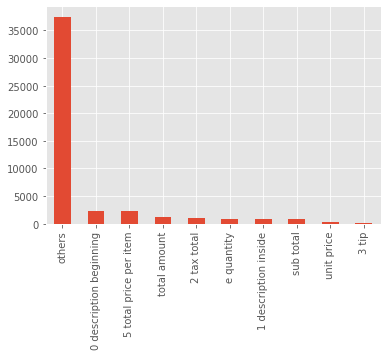

In [ ]:
# plot for class frequency imbalance
plt.style.use('ggplot')
train_unique['label'].value_counts().plot(kind='bar')

list of class names: ['0 description beginning', '1 description inside', '2 tax total', '3 tip', '5 total price per item', 'e quantity', 'others', 'sub total', 'total amount', 'unit price']
positive weights: [0.95010334 0.98188454 0.9797334  0.99685776 0.9530769  0.9814627
 0.20935088 0.9819056  0.9730482  0.99257666]
negative weights: [0.04989666 0.01811548 0.02026656 0.00314227 0.04692311 0.01853726
 0.7906491  0.01809439 0.02695179 0.00742334]


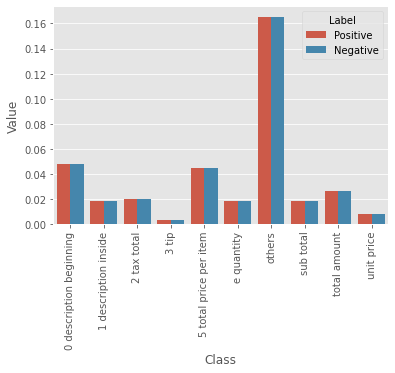

In [ ]:
# balancing the class frequencies by assinging the weights 
pos_freq, neg_freq = compute_class_freqs(y_train)
neg_weights = pos_freq
pos_weights = neg_freq

pos_contribution = pos_freq * pos_weights 
neg_contribution = neg_freq * neg_weights

print('list of class names:', classes)
print('positive weights:', pos_weights)
print('negative weights:', neg_weights)

plotData = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_contribution})
plotData = plotData.append([{"Class": classes[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=plotData)

In [ ]:
# weighted cross entropy loss function
def get_weighted_loss(pos_weights, neg_weights, epsilon = 1e-7):
  
  
  def weighted_loss(y_true, y_pred):
        loss = 0.0
        loss_pos = - K.mean(pos_weights * y_true * K.log(y_pred + epsilon))
        loss_neg = - K.mean(neg_weights * (1 - y_true) * K.log(1 - y_pred + epsilon))
        loss += loss_pos + loss_neg
        
        return loss


  return weighted_loss

In [ ]:
def get_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=102, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10, activation='softmax'))
	# Compile model
  model.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer='adam', metrics=['accuracy'])
  
  return model

### 1-Fold Training

In [ ]:
x, x_val, y, y_val = train_test_split(x_train, y_train, test_size=0.33, shuffle=True, stratify=y_train, random_state=12)
print(x.shape)
print(y.shape)
print(x_val.shape)
print(y_val.shape)

(31770, 102)
(31770, 10)
(15648, 102)
(15648, 10)


In [ ]:
nnModel = get_model()
history = nnModel.fit(x, y, steps_per_epoch = x.shape[0]//1000, epochs = 100, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/100
31/31 [==============================] - 2s 43ms/step - loss: 0.0806 - accuracy: 0.5201 - val_loss: 0.0720 - val_accuracy: 0.7396
Epoch 2/100
31/31 [==============================] - 1s 35ms/step - loss: 0.0677 - accuracy: 0.7452 - val_loss: 0.0647 - val_accuracy: 0.7160
Epoch 3/100
31/31 [==============================] - 1s 36ms/step - loss: 0.0631 - accuracy: 0.6850 - val_loss: 0.0621 - val_accuracy: 0.6317
Epoch 4/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0609 - accuracy: 0.6719 - val_loss: 0.0601 - val_accuracy: 0.6614
Epoch 5/100
31/31 [==============================] - 1s 37ms/step - loss: 0.0595 - accuracy: 0.6446 - val_loss: 0.0590 - val_accuracy: 0.6099
Epoch 6/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0583 - accuracy: 0.6347 - val_loss: 0.0584 - val_accuracy: 0.5753
Epoch 7/100
31/31 [==============================] - 1s 37ms/step - loss: 0.0575 - accuracy: 0.6272 - val_loss: 0.0576 - val_accuracy: 0.6791
Epoch 

In [ ]:
# neural network prediction
prob = nnModel.predict(x_val)
pred = np.argmax(prob, axis=-1)
y_true = np.argmax(y_val, axis=-1)
score = metrics.f1_score(y_true, pred, labels=range(len(classes)), average='macro')
print('f1-score', score)

f1-score 0.24324329587517543


In [ ]:
def get_dict_predict(models, dataframe):
  output = {}
  for i in range(dataframe.shape[0]):
    preds = [classes[np.argmax(models.predict(np.resize(np.append(np.append(model[dataframe.loc[i,'text'][j]], float(dataframe.loc[i,'center'][j][0])/mx_x), \
             float(dataframe.loc[i,'center'][j][1])/mx_y), (1,102))), axis = -1)[0]] for j in range(len(dataframe.loc[i,'text']))]
    preds = dict(zip(map(str, range(len(preds))), preds))
    output[dataframe.loc[i,'image']] = preds
  return output

In [ ]:
output = get_dict_predict(nnModel, val_data)

In [ ]:
with open("DS_IITK_Dataholic_3.json", "w") as outfile:
    json.dump(output, outfile, sort_keys=True)

In [ ]:
# random forest prediction
rfc = RandomForestClassifier(random_state=12)
rfc.fit(x,y)
prob = rfc.predict(x_val)
pred = np.argmax(prob, axis=-1)
score = metrics.f1_score(y_true, pred, labels=range(len(classes)), average='macro')
print('f1-score', score)

f1-score 0.41060601129740587


In [ ]:
rfc = RandomForestClassifier(random_state=12)
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [ ]:
output_rcf = get_dict_predict(rfc, val_data)

In [ ]:
with open("DS_IITK_Dataholic_4.json", "w") as outfile:
    json.dump(output_rcf, outfile, sort_keys=True)

In [ ]:
# gradient boosting prediction
gbc = GradientBoostingClassifier(random_state=12)
gbc.fit(x,np.argmax(y,axis=-1))
pred = gbc.predict(x_val)
score = metrics.f1_score(y_true, pred, labels=range(len(classes)), average='macro')
print('f1-score', score)

f1-score 0.27443749923963734


In [ ]:
def get_GBCdict_predict(models, dataframe):
  output = {}
  for i in range(dataframe.shape[0]):
    preds = [classes[int(models.predict(np.resize(np.append(np.append(model[dataframe.loc[i,'text'][j]], float(dataframe.loc[i,'center'][j][0])/mx_x), \
             float(dataframe.loc[i,'center'][j][1])/mx_y), (1,102))))] for j in range(len(dataframe.loc[i,'text']))]
    preds = dict(zip(map(str, range(len(preds))), preds))
    output[dataframe.loc[i,'image']] = preds
  return output

In [ ]:
output_gbc = get_GBCdict_predict(gbc, val_data)

In [ ]:
with open("DS_IITK_Dataholic_5.json", "w") as outfile:
    json.dump(output_gbc, outfile, sort_keys=True)

### K-Fold Training

In [ ]:
def K_fold_training(folds = 5):
    histories = []
    models = []
    
    kfold = StratifiedKFold(folds, shuffle = True, random_state = 12)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(x_train, encoded_Y)):
      print(); print('#'*25)
      print('### FOLD', f+1)
      print('#'*25)
      train_dataset = pd.DataFrame(x_train).loc[trn_ind].values
      print(train_dataset.shape)
      train_y = pd.DataFrame(y_train).loc[trn_ind].values
      val_dataset = pd.DataFrame(x_train).loc[val_ind].values
      val_y = pd.DataFrame(y_train).loc[val_ind].values
      
      model = get_model()
      history = model.fit(
          train_dataset, train_y, 
          steps_per_epoch = train_dataset.shape[0] // 1000,
          epochs = 100,
          validation_data = (val_dataset, val_y),
          verbose=1
      )
      models.append(model)
      histories.append(history)
    return models, histories

def K_predict(models, val, folds=5):
    # get the mean probability of the folds models
    probabilities = np.average([models[i].predict(val) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    # print('Generating submission.csv file...')
    test_Y = classes[predictions[0]]
    return test_Y

In [ ]:
models, histories = K_fold_training(folds = 3)


#########################
### FOLD 1
#########################
(13360, 100)
Epoch 1/100
13/13 [==============================] - 1s 46ms/step - loss: 0.1218 - accuracy: 0.6365 - val_loss: 0.1184 - val_accuracy: 0.6852
Epoch 2/100
13/13 [==============================] - 0s 34ms/step - loss: 0.1133 - accuracy: 0.6852 - val_loss: 0.1082 - val_accuracy: 0.6852
Epoch 3/100
13/13 [==============================] - 0s 33ms/step - loss: 0.1066 - accuracy: 0.6852 - val_loss: 0.1053 - val_accuracy: 0.6852
Epoch 4/100
13/13 [==============================] - 0s 34ms/step - loss: 0.1048 - accuracy: 0.6852 - val_loss: 0.1044 - val_accuracy: 0.6852
Epoch 5/100
13/13 [==============================] - 1s 41ms/step - loss: 0.1042 - accuracy: 0.6852 - val_loss: 0.1040 - val_accuracy: 0.6852
Epoch 6/100
13/13 [==============================] - 0s 33ms/step - loss: 0.1040 - accuracy: 0.6852 - val_loss: 0.1037 - val_accuracy: 0.6852
Epoch 7/100
13/13 [==============================] - 0s 32ms/step - los

In [ ]:
def getKFold_dict_predict(models, dataframe):
  output = {}
  for i in range(dataframe.shape[0]):
    preds = [K_predict(models, np.resize(model[dataframe.loc[i,'text'][j]], (1,100)), 3) for j in range(len(dataframe.loc[i,'text']))]
    preds = dict(zip(map(str, range(len(preds))), preds))
    output[dataframe.loc[i,'image']] = preds
  return output

In [ ]:
Kfold_output = getKFold_dict_predict(models, val_data)

In [ ]:
with open("DS_IITK_Dataholic_2.json", "w") as outfile:
    json.dump(Kfold_output, outfile, sort_keys=True)

## Nishtha

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def get_model():
	# create model
  model = RandomForestClassifier()
  return model

In [ ]:
x, x_val, y, y_val = train_test_split(x_train, y_train, test_size=0.3, shuffle=True, stratify=y_train, random_state=12)
print(x.shape)
print(y.shape)
print(x_val.shape)
print(y_val.shape)

(14028, 100)
(14028, 10)
(6012, 100)
(6012, 10)


In [ ]:
#####   SAMPLING USELESS  #########

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# oversample = SMOTE()
# x, y = oversample.fit_resample(x, y)
undersample = RandomUnderSampler()
x, y = undersample.fit_resample(x, y)
print(x.shape)
print(y.shape)

(96120, 100)
(96120, 10)


In [ ]:
nnModel = get_model()
nnModel.fit(x, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
prob = nnModel.predict(x_val)
pred = np.argmax(prob, axis=-1)
y_true = np.argmax(y_val, axis=-1)
score = metrics.f1_score(y_true, pred, labels=range(len(classes)), average='macro')
print('f1-score', score)

f1-score 0.01912416547762381


In [ ]:
def get_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=100, activation='relu'))
  # model.add(Dense(200, input_dim=200, activation='relu'))
  model.add(Dense(64, input_dim=128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
	# Compile model
  model.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer='adam', metrics=['accuracy'])
  
  return model

In [ ]:
x, x_val, y, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=12)
print(x.shape)
print(y.shape)
print(x_val.shape)
print(y_val.shape)

(109848, 100)
(109848, 10)
(27462, 100)
(27462, 10)


In [ ]:
nnModel = get_model()
y = y.astype(float)
history = nnModel.fit(x, y, steps_per_epoch = x.shape[0]//1000, epochs = 100, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/100
96/96 [==============================] - 1s 10ms/step - loss: 0.2083 - accuracy: 0.1233 - val_loss: 0.1512 - val_accuracy: 0.0258
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.2039 - accuracy: 0.1386 - val_loss: 0.1539 - val_accuracy: 0.0547
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.2023 - accuracy: 0.1548 - val_loss: 0.1519 - val_accuracy: 0.0487
Epoch 4/100
96/96 [==============================] - 1s 8ms/step - loss: 0.2000 - accuracy: 0.1769 - val_loss: 0.1516 - val_accuracy: 0.0364
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.1962 - accuracy: 0.2112 - val_loss: 0.1516 - val_accuracy: 0.0449
Epoch 6/100
96/96 [==============================] - 1s 9ms/step - loss: 0.1913 - accuracy: 0.2253 - val_loss: 0.1513 - val_accuracy: 0.0398
Epoch 7/100
96/96 [==============================] - 1s 9ms/step - loss: 0.1865 - accuracy: 0.2416 - val_loss: 0.1515 - val_accuracy: 0.0424
Epoch 8/1

In [ ]:
prob = nnModel.predict(x_val)
pred = np.argmax(prob, axis=-1)
y_true = np.argmax(y_val, axis=-1)
score = metrics.f1_score(y_true, pred, labels=range(len(classes)), average='macro')
print('f1-score', score)

f1-score 0.0475180693621798


# **ADITYA SINGH**
<img src= "https://i.kym-cdn.com/photos/images/newsfeed/000/517/111/fbd.jpg" width = '300'>

## Old

In [ ]:
# github path for loading data
!git clone https://github.com/rawakash66/AMEX_2021_Data_Science_Challenge -q
# moving into the directory
%cd AMEX_2021_Data_Science_Challenge
# unzipping files
!unzip -qq "train.zip"
!unzip -qq "val.zip"
print("files unzipped")
# file paths for input and label data
train_input_path = "train/input"
train_output_path = "train/output"
val_input_path = "round1/input"

/content/AMEX_2021_Data_Science_Challenge/AMEX_2021_Data_Science_Challenge
files unzipped


In [ ]:
# functions for creating dataframe for input and label
def read_test_files(inputPath):
  json_inputfiles_list = sorted([json_file for json_file in os.listdir(inputPath) if json_file.endswith('.json')])
  json_data = pd.DataFrame(columns=['image','text'])
  
  for idx, img in enumerate(json_inputfiles_list):
    name = img.split('.')[0]
    with open(os.path.join(inputPath,img)) as json_file:
      json_text = json.load(json_file)
      text = [json_text['textAnnotations'][i]['description'].strip().lower() for i in range(len(json_text['textAnnotations']))]
      json_data.loc[idx] = [name, text]
  
  return json_data

def read_train_files(labelPath):
  json_labelfiles_list = sorted([json_file for json_file in os.listdir(labelPath) if json_file.endswith('.json')])
  json_data = pd.DataFrame(columns=['image', 'text', 'labels'])
  
  for idx, img in enumerate(json_labelfiles_list):
    name = img.split('.')[0][0:-7]
    with open(os.path.join(labelPath,img)) as json_file:
      json_text = json.load(json_file)
      label = [json_text[i]['label'].strip() for i in range(len(json_text))]
      text = [json_text[i]['text'].strip().lower() for i in range(len(json_text))]
      json_data.loc[idx] = [name, text, label]
  
  return json_data

In [ ]:
# reading files
data = read_train_files(train_output_path)
data.head()

,image,text,labels
0,image_0000,"[s3, merchant name, merchant name, merchant ad...","[others, others, others, others, others, other..."
1,image_0001,"[merchant name, merchant address, merchant pho...","[others, others, others, others, others, other..."
2,image_0002,"[date:, card type, acct #:, card entry:, trans...","[others, others, others, others, others, other..."
3,image_0003,"[.ll, vodafone in, 17:20, @ 'o, 316, powered b...","[others, others, others, others, others, other..."
4,image_0004,"[will ........ transaction recoro, merchant ad...","[others, others, others, others, others, other..."


In [ ]:
val_data = read_test_files(val_input_path)
val_data.head()

,image,text
0,image_0197,"[merchant name, merchant address, tel, merchan..."
1,image_0198,"[merchant name, merchant address, merchant pho..."
2,image_0199,"[11/13/2019, 10:41, =======, merchant name, ch..."
3,image_0200,"[merchant name, merchant address, merchant add..."
4,image_0991,"[=, page, down, -, -, merchant name, merchant ..."


In [ ]:
text = np.array(list(chain.from_iterable(data['text'])))
text2d = text.reshape(-1,1)
labels = np.array(list(chain.from_iterable(data['labels'])))
labels2d = labels.reshape(-1,1)
train = pd.DataFrame(data = np.hstack((text2d, labels2d)),columns = ['text', 'labels'])
train_unique = train.drop_duplicates(ignore_index=True)
print('shape after removing duplicates', train_unique.shape)
train_unique.head()

shape after removing duplicates (20040, 2)


,text,labels
0,s3,others
1,merchant name,others
2,merchant address,others
3,merchant phone,others
4,check44167,others


In [ ]:
# Use data['text'] as input to Word2Vec as it takes sentence as input 
# and breaks it into words by spaces
model = Word2Vec(sentences=data['text'], min_count=1)
print(model)
# Words trained in the model vocabulary
words = list(model.wv.vocab)
print(words)
print(np.unique(labels))

Word2Vec(vocab=18558, size=100, alpha=0.025)
['s3', 'merchant name', 'merchant address', 'merchant phone', 'check44167', 'table $3', '07/11/19 12:', '1', 'refreshing tuna poke rice bowl', 'coke', '$158.', '$28', 'sub- total', 'service charge', '$186.', '$18', 'total', '$204.6', 'chk 712991', '11/15/2019 08:45 am', '2 reg:', '1513490', 'drawer:', 'berry trio yogurt', 'gr flat white', '3.95', '4.95', 'amex', 'xxxxxxxxxxxx1000', 'quick chip', 'purchase', 'reference #:', 'app label:', 'auth #:', 'aid:', 'tvr:', 'tsi:', '8.90', 'card entry:', 'trans type:', '00000135', 'american express', '803099', 'a000000025010801', '0000008000', 'e800', 'subtotal', 'change due', '$8.90', '$0.00', 'check closed', 'join our loyalty program', 'sign up for promotional emails', 'or download our app', 'some restrictions apply', 'starbucks rewards@', 'visit starbucks.com/rewards', 'at participating stores', 'date:', 'card type', 'acct #:', 'auth code:', 'check', 'check id', 'server', "oct28'19 09:05am", 'xxxxxx

In [ ]:
# Remove rows that are not part of model vocabulary
train_unique = train_unique[train_unique['text'].isin(words)]

# Update text and label according to train_unique with each row unique
text = np.array(train_unique['text'])
labels = np.array(train_unique['labels'])
print(list(text))
print(labels.shape)

['s3', 'merchant name', 'merchant address', 'merchant phone', 'check44167', 'table $3', '07/11/19 12:', '1', 'refreshing tuna poke rice bowl', 'coke', '1', '$158.', '$28', 'sub- total', 'service charge', '$186.', '$18', 'total', '$204.6', 'chk 712991', '11/15/2019 08:45 am', '2 reg:', '1513490', 'drawer:', 'berry trio yogurt', 'gr flat white', '3.95', '4.95', 'amex', 'xxxxxxxxxxxx1000', 'quick chip', 'purchase', 'reference #:', 'app label:', 'auth #:', 'aid:', 'tvr:', 'tsi:', '8.90', 'card entry:', 'trans type:', '00000135', 'american express', '803099', 'a000000025010801', '0000008000', 'e800', 'subtotal', 'change due', '$8.90', '$8.90', '$0.00', 'check closed', 'join our loyalty program', 'sign up for promotional emails', 'or download our app', 'some restrictions apply', 'starbucks rewards@', 'visit starbucks.com/rewards', 'at participating stores', 'date:', 'card type', 'acct #:', 'auth code:', 'check', 'check id', 'server', "oct28'19 09:05am", 'xxxxxxxxxxx1000', 'swiped', '585879',

In [ ]:
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=18558, size=100, alpha=0.025)


In [ ]:
# Training input
X = model[train_unique['text']]
X.shape

(20040, 100)

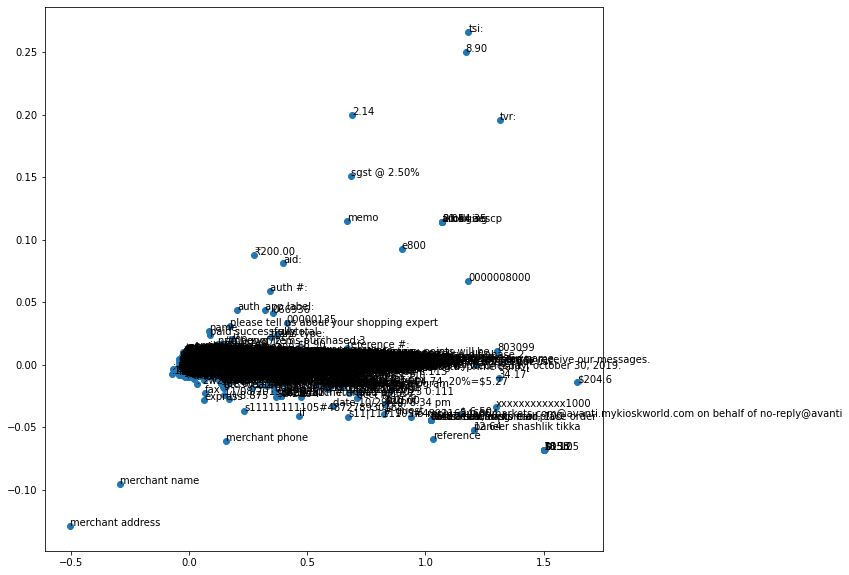

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize = (10,10))
plt.scatter(result[:, 0], result[:, 1])

words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
print(dummy_y.shape)

(20040, 10)


In [ ]:
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(200, input_dim=100, activation='relu'))
  model.add(Dense(200, input_dim=200, activation='relu'))
  model.add(Dense(50, input_dim=50, activation='relu'))
  model.add(Dense(10, activation='softmax'))
	# Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
try:
  assert X.shape[0] == dummy_y.shape[0]
except:
  print("Unmatched number of samples")
  print("X datasize:", X.shape[0])
  print("Y datasize:", dummy_y.shape[0])

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=1000, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## 11 November

In [ ]:
import keras
from keras import layers
import keras.backend as K


# This is our input vector
input_x = keras.Input(shape=(102,))
# "encoded" is the encoded representation of the input
encoded1 = layers.Dense(64, activation='selu')(input_x)
encoded2 = layers.Dense(32, activation='tanh')(encoded1)
# "decoded" is the lossy reconstruction of the input
decoded1 = layers.Dense(64, activation='selu')(encoded2)
decoded = layers.Dense(102, activation = None)(decoded1)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_x, decoded)

myencoder = keras.Model(input_x, encoded2)
encoded_input = keras.Input(shape=(32,))
# Retrieve the last layer of the autoencoder model
decoder_layer1 = autoencoder.layers[-2]
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
mydecoder = keras.Model(encoded_input, decoder_layer(decoder_layer1(encoded_input)))

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')
auto_history = autoencoder.fit(np.asarray(x).astype('float32'), np.asarray(x).astype('float32'),
                epochs=60,
                batch_size=512,
                shuffle=True,
                validation_data=(np.asarray(x_val).astype('float32'), np.asarray(x_val).astype('float32')))

Epoch 1/60
63/63 [==============================] - 1s 6ms/step - loss: 0.0247 - val_loss: 0.0094
Epoch 2/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 3/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 4/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 6/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 7/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 10/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 11/60
63/63 [

dict_keys(['loss', 'val_loss'])


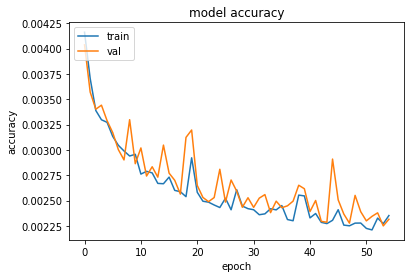

In [ ]:
# list all data in history
print(auto_history.history.keys())
# summarize history for accuracy
plt.plot(auto_history.history['loss'][5:])
plt.plot(auto_history.history['val_loss'][5:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
encoded_x = myencoder.predict(np.asarray(x).astype('float32'))
decoded_x = mydecoder.predict(encoded_x)
sum(abs(decoded_x[0] - x[0].astype('float32')))

0.23257688898593187